Description

This file trains the XGBoost models and creates the reconstructions. 

New to this code, test on data from every fifth month (train on the prior four)
 Run 5 times to reconstruct

Inputs

In [36]:
# =========================================
# For accessing directories
# =========================================
#root_dir = "/data/artemis/workspace/vbennington/SOCAT_ML/pCO2_DIC_Taka"
root_dir = "/data/artemis/workspace/vbennington/SOCAT_ML/pCO2_DIC"

reference_output_dir = f"{root_dir}/references"
data_output_dir = f"{root_dir}/data/processed"
model_output_dir = f"{root_dir}/models/trained"
recon_output_dir = f"{root_dir}/models/reconstructions"
other_output_dir = f"{root_dir}/models/performance_metrics"

# Set this:
run = 5

approach = 'xg'
approach_output_dir = f"{other_output_dir}/{approach}"
# =========================================
# Number of cores you have access to for model training
# =========================================
jobs = 30

In [3]:
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
import scipy
import sklearn.linear_model 
import pickle

Modules

In [5]:
# standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import random

# machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
import xgboost as xgb     # extreme gradient boosting (XGB
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
import sklearn.model_selection as mselect

# Python file with supporting functions
import pre_SOCAT

Predefined Values

In [10]:
# Loading references

In [37]:
# Want to train with 4 out of every 5 months, and test on the fifth month
# 5 runs, each training / testing on different set of months

date_range_start = '1982-01-01T00:00:00.000000000'
date_range_end = '2019-12-01T00:00:00.000000000'

# Run 1 (Mod 5, offset 0) ####
# create date vector
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')
select_dates = []
test_dates = []

if run ==1:
    for i in range(0,len(dates)):
        if i % 5 != 0:  # months 0, 5, 10, 15, 20, 25, ... 
            select_dates.append(dates[i])
        if i % 5 == 0:
            test_dates.append(dates[i])
    year_mon = []
    for i in range(0,len(select_dates)):
        tmp = select_dates[i]
        year_mon.append(f"{tmp.year}-{tmp.month}")
    test_year_mon = []
    for i in range(0,len(test_dates)):
        tmp = test_dates[i]
        test_year_mon.append(f"{tmp.year}-{tmp.month}")
    
# Run 2 (Mod 5, offset 1)    
if run ==2:
    for i in range(0,len(dates)):
        if (i+1) % 5 != 0:  # months 0, 5, 10, 15, 20, 25, ... 
            select_dates.append(dates[i])
        if (i+1) % 5 == 0:
            test_dates.append(dates[i])
    year_mon = []
    for i in range(0,len(select_dates)):
        tmp = select_dates[i]
        year_mon.append(f"{tmp.year}-{tmp.month}")
    test_year_mon = []
    for i in range(0,len(test_dates)):
        tmp = test_dates[i]
        test_year_mon.append(f"{tmp.year}-{tmp.month}")
        
# Run 3 (Mod 5, offset 2)    
if run ==3:
    for i in range(0,len(dates)):
        if (i+2) % 5 != 0:  # months 0, 5, 10, 15, 20, 25, ... 
            select_dates.append(dates[i])
        if (i+2) % 5 == 0:
            test_dates.append(dates[i])
    year_mon = []
    for i in range(0,len(select_dates)):
        tmp = select_dates[i]
        year_mon.append(f"{tmp.year}-{tmp.month}")
    test_year_mon = []
    for i in range(0,len(test_dates)):
        tmp = test_dates[i]
        test_year_mon.append(f"{tmp.year}-{tmp.month}")
        
# Run 4 (Mod 5, offset 3)    
if run ==4:
    for i in range(0,len(dates)):
        if (i+3) % 5 != 0:  # months 0, 5, 10, 15, 20, 25, ... 
            select_dates.append(dates[i])
        if (i+3) % 5 == 0:
            test_dates.append(dates[i])
    year_mon = []
    for i in range(0,len(select_dates)):
        tmp = select_dates[i]
        year_mon.append(f"{tmp.year}-{tmp.month}")
    test_year_mon = []
    for i in range(0,len(test_dates)):
        tmp = test_dates[i]
        test_year_mon.append(f"{tmp.year}-{tmp.month}")
        
# Run 5 (Mod 5, offset 4)    
if run ==5:
    for i in range(0,len(dates)):
        if (i+4) % 5 != 0:  # months 0, 5, 10, 15, 20, 25, ... 
            select_dates.append(dates[i])
        if (i+4) % 5 == 0:
            test_dates.append(dates[i])
    year_mon = []
    for i in range(0,len(select_dates)):
        tmp = select_dates[i]
        year_mon.append(f"{tmp.year}-{tmp.month}")
    test_year_mon = []
    for i in range(0,len(test_dates)):
        tmp = test_dates[i]
        test_year_mon.append(f"{tmp.year}-{tmp.month}")

In [38]:
approach = 'xg'
approach_output_dir = f"{other_output_dir}/{approach}"

random_seeds_ens = np.array([[72,47],[57,16],[28,2],[99,31],[68,91]]) #pCO2_DIC_Taka, pCO2_DIC
random_seeds = random_seeds_ens[run-1]
print(random_seeds)

if run==1:
    first_run = True
else:
    first_run = False

[68 91]


In [9]:
param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"
with open(param_fname, 'rb') as handle:
    best_params = pickle.load(handle)
print(best_params)

{'max_depth': 9, 'n_estimators': 1000}


In [39]:
if first_run:
    best_params = {} # Uncomment if running cross validation to find best params
else:
    param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"
    with open(param_fname, 'rb') as handle:
        best_params = pickle.load(handle)
        print(best_params)
    
test_performance = defaultdict(dict)

K_folds = 3
approach = "xg"

print(datetime.datetime.now())

# Data file path
data_dir = f"{data_output_dir}"
fname = f"data_clean_2D_mon_1x1_198201-201912.pkl"
file_path = f"{data_dir}/{fname}"
        
# Read in data, create some selection filters, produce a reduced dataframe
df = pd.read_pickle(file_path)

# Get rid of features we never use:
df = df.drop(columns=['chl','mld'])

# Test on every fifth month to reduce autocorrelation along cruise tracks, but still sample many climate anomalies...
df['year'] = df.index.get_level_values('time').year
df['mon'] = df.index.get_level_values('time').month
df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)
# Get rid of N    
recon_sel = (~df[features_sel+['net_mask']].isna().any(axis=1))   # Dont' have dpCO2 for non-SOCAT locations, but have features

################################################################################################################################        
sel = (recon_sel & (df['socat_mask'] == 1))).to_numpy().ravel()           # locations not masked AND IN SOCAT SAMPLING and within reason
print("SOCAT length =",sum(sel))

################################################################################################################################
# Separate the data sets
###################################################################################################################################

train_val_sel = ((sel) & (pd.Series(df['year_month']).isin(year_mon))).to_numpy().ravel()
print("Train/Val length = ",sum(train_val_sel))

test_sel = ((sel) & (pd.Series(df['year_month']).isin(test_year_mon))).to_numpy().ravel()   # Should be along SOCAT track
print("Test length =",sum(test_sel))     


################################################################################################################################
        
# Convert dataframe to numpy arrays, train/val/test split
X = df.loc[sel,features_sel].to_numpy()         
y = df.loc[sel,target_sel].to_numpy().ravel()

# Where we want dpCO2 reconstructed
X_recon = df.loc[recon_sel,features_sel].to_numpy()         


#X_train, X_val, y_train, y_val = mselect.train_test_split(X_train_val, y_train_val, test_size=val_prop, random_state=42)  
# Convert dataframe to numpy arrays, train/val/test split
X_train_val = df.loc[train_val_sel,features_sel].to_numpy()                # create Xtrain and Xtest to randomly select from for X_train and X_test
y_train_val = df.loc[train_val_sel,target_sel].to_numpy().ravel()


if first_run:
    # Within cross validation, split by year groups (Group K Fold split):
    #final_groups = df.index.get_level_values('time').year[train_val_sel]
    #gkf = GroupKFold(n_splits=K_folds).split(X_train_val,y_train_val,final_groups)
    
    # Define the model with validation set #####  
    model = XGBRegressor(random_state=random_seeds[0], n_jobs=jobs)
    param_grid = xg_param_grid
    grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=K_folds, return_train_score=False, refit=True)
    grid.fit(X_train_val,y_train_val)
    best_params = grid.best_params_
    print(best_params)

# Fit the model on train/validation data
model = XGBRegressor(random_state=random_seeds[1], **best_params, n_jobs=jobs)
model.fit(X_train_val, y_train_val)       
print(np.nanmean(y_train_val))

# Save the model
pre_SOCAT.save_model(model, model_output_dir, approach, run)   #Uncomment when actually running

################ TEST ####################################################################################################
X_test = df.loc[test_sel,features_sel].to_numpy()                #  Test metrics on all of SOCAT data from test years
y_test = df.loc[test_sel,target_sel].to_numpy().ravel()    
        
# Calculate some test error metrics and store in a dictionary
y_pred_test = model.predict(X_test)

# for pCO2_DIC
test_performance = pre_SOCAT.evaluate_test(y_test, y_pred_test)
print(test_performance)

# for pCO2
y_final = df.loc[test_sel,final_sel].to_numpy().ravel()  # Real pCO2 from SOCAT
y_pco2t = df.loc[test_sel,'pCO2_T'].to_numpy().ravel() # pCO2_T
y_pred_final = y_pred_test + y_pco2t

pco2_performance = pre_SOCAT.evaluate_test(y_final, y_pred_final)
print(pco2_performance)
######################################################################################


{'max_depth': 9, 'n_estimators': 1000}
2021-11-10 16:45:33.495668
SOCAT length = 262710
Train/Val length =  210875
Test length = 51835
2.7555913265108702
Starting model saving process
Save complete
{'mse': 257.4894562012584, 'mae': 10.734984592813886, 'medae': 7.276587283585798, 'max_error': 206.22397069117335, 'bias': -0.33294141749300765, 'r2': 0.8467326748284667, 'corr': 0.9202204196764717, 'cent_rmse': 16.043023574625973, 'stdev': 37.826004, 'amp_ratio': 0.888616622087397, 'stdev_ref': 40.98783091387805, 'range_ref': 398.3222930440106, 'iqr_ref': 45.12717785084226}
{'mse': 257.4894562012584, 'mae': 10.734984592813886, 'medae': 7.276587283585798, 'max_error': 206.22397069117335, 'bias': -0.33294135920851886, 'r2': 0.7990566520614615, 'corr': 0.8944096451059864, 'cent_rmse': 16.043023600699055, 'stdev': 33.04537246846396, 'amp_ratio': 0.8619354300039148, 'stdev_ref': 35.79669308054935, 'range_ref': 380.9914182243652, 'iqr_ref': 42.17119094776905}


In [40]:
# Make room for our reconstruction:
df=df.drop(columns=['sss','sst','mld_log','chl_log','sss_anom','sst_anom','A','B','C','T0','T1'])

# Everywhere, SOCAT and non-SOCAT ####################################################
y_recon = model.predict(X_recon)

# Full reconstruction ##
df['pCO2_DIC_recon'] = np.nan
df.loc[recon_sel,['pCO2_DIC_recon']] = y_recon   

# Full reconstruction ##
df['pCO2_recon'] = np.nan
df.loc[recon_sel,['pCO2_recon']] = y_recon + df.loc[recon_sel,'pCO2_T'].to_numpy() # pCO2-DIC + pCO2_T

df['pCO2_test_recon'] = np.nan
df.loc[test_sel,['pCO2_test_recon']] = y_pred_final

df['pCO2_test'] = np.nan
df.loc[test_sel,['pCO2_test']] = y_final

df['pCO2_DIC_test_recon'] = np.nan
df.loc[test_sel,['pCO2_DIC_test_recon']] = y_pred_test

df['pCO2_DIC_test'] = np.nan
df.loc[test_sel,['pCO2_DIC_test']] = y_test

        
DS_recon = df[['net_mask','socat_mask','pCO2_DIC', 'pCO2_DIC_recon','pCO2','pCO2_recon','pCO2_T','pCO2_DIC_test','pCO2_DIC_test_recon','pCO2_test','pCO2_test_recon']].to_xarray()

########## SAVE ####################################################################################################
pre_SOCAT.save_recon(DS_recon, recon_output_dir, approach, run)   # Uncomment when actually running

print(datetime.datetime.now())

Starting reconstruction saving process
Save complete
2021-11-10 16:53:54.025333


In [41]:
# Saving best parameters and performance metrics
approach_output_dir = f"{other_output_dir}/{approach}"
test_perform_fname = f"{approach_output_dir}/{approach}_test_performance_run{run}_dict.pickle"

Path(approach_output_dir).mkdir(parents=True, exist_ok=True)

###############################################################################
if run==1: # Only write out best params for first model
    param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"  # Keep same for all ensemble members
    with open(param_fname, 'wb') as handle:
        pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
################################################################################    
    
with open(test_perform_fname, 'wb') as handle:
    pickle.dump(pco2_performance, handle)    # pco2 statistics, as opposed to pCO2-Residual statistics
    
# Convert performance metrics to dataframes
test_df = pd.DataFrame.from_dict(pco2_performance,orient='index')

# Save the dataframes too
test_df_fname = f"{approach_output_dir}/{approach}_test_performance_run{run}_df.pickle"

test_df.to_pickle(test_df_fname)

Text(0.5,0,'XGBoost dpco2 Feature Importance')

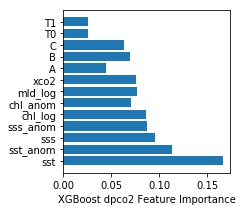

In [42]:
fig = plt.figure(figsize=(3,3))
plt.barh(features_sel, model.feature_importances_)
plt.xlabel("XGBoost dpco2 Feature Importance")